# Prediction - European Calls

In [13]:
%run examples/key_imports.py
%run examples/bs.py
%run examples/nn_archi.py
%run examples/utils.py

X_df = pd.read_csv("bs.csv")
feat_names = ['log(S/K)', 'ttm']
f_to_i = lambda x: feat_names.index(x)
Xs = X_df[feat_names].values
ys = X_df['call_true']

print("BASELINE MSE: ", np.mean((ys - ys.mean()) ** 2))
print("BASELINE MAE: ", np.mean(np.abs(ys - ys.mean())))

all_res = []

BASELINE MSE:  0.27735335419325
BASELINE MAE:  0.31919378735557496


In [14]:
HIDDEN_UNITS = 100
LAYERS = 2
dropout_ratio = 0.0
HIDDEN_ACT = 'softplus'
N_FEATS = 2
OUTPUT_ACT = 'softplus'
DROPOUT_RATIO = 0.0
LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 10
BATCH_NORM = False

loss_fn = tf.keras.losses.MeanSquaredError()

METRICS = [tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()]
VAL_SPLIT = 0.2
CALLBACKS = [EarlyStopping(patience=5)]


opt = Adam(learning_rate = LR)
ffn = make_model(N_FEATS, 
                 HIDDEN_UNITS, 
                 LAYERS, 
                 DROPOUT_RATIO, 
                 HIDDEN_ACT, 
                 OUTPUT_ACT, 
                 BATCH_NORM)


ffn.compile(optimizer=opt, loss=loss_fn, metrics = METRICS)
history = ffn.fit(Xs, ys, 
                  epochs = EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_split = VAL_SPLIT,
                  shuffle=True,
                  callbacks=CALLBACKS)

0.27735335419325
0.31919378735557496
Epoch 1/10
1639/1639 [==============================] - 3s 2ms/step - loss: 0.0265 - mean_absolute_error: 0.0552 - root_mean_squared_error: 0.1629 - val_loss: 0.0018 - val_mean_absolute_error: 0.0214 - val_root_mean_squared_error: 0.0428
Epoch 2/10
1639/1639 [==============================] - 3s 2ms/step - loss: 0.0035 - mean_absolute_error: 0.0260 - root_mean_squared_error: 0.0593 - val_loss: 0.0031 - val_mean_absolute_error: 0.0299 - val_root_mean_squared_error: 0.0554
Epoch 3/10
1639/1639 [==============================] - 3s 2ms/step - loss: 0.0031 - mean_absolute_error: 0.0263 - root_mean_squared_error: 0.0558 - val_loss: 0.0022 - val_mean_absolute_error: 0.0267 - val_root_mean_squared_error: 0.0465
Epoch 4/10
1639/1639 [==============================] - 3s 2ms/step - loss: 0.0026 - mean_absolute_error: 0.0260 - root_mean_squared_error: 0.0508 - val_loss: 0.0014 - val_mean_absolute_error: 0.0223 - val_root_mean_squared_error: 0.0377
Epoch 5/10


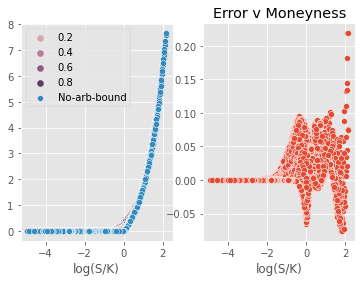

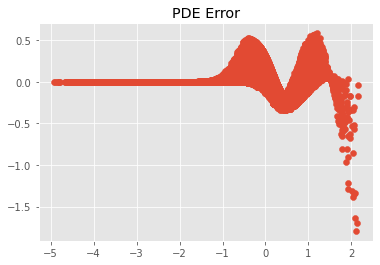

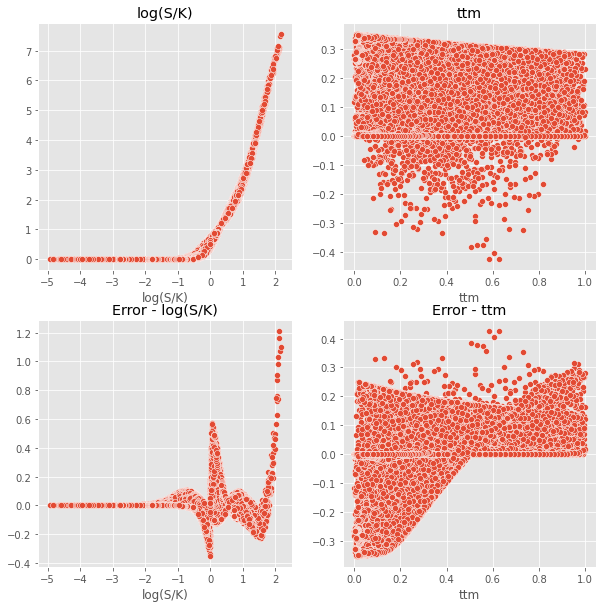

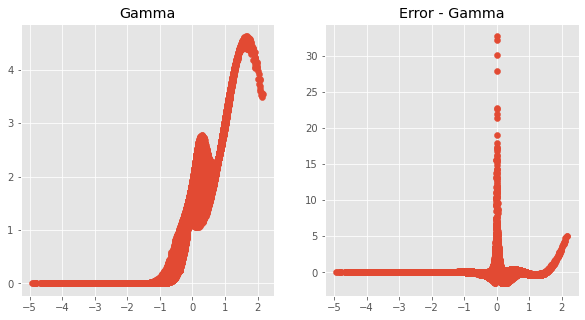

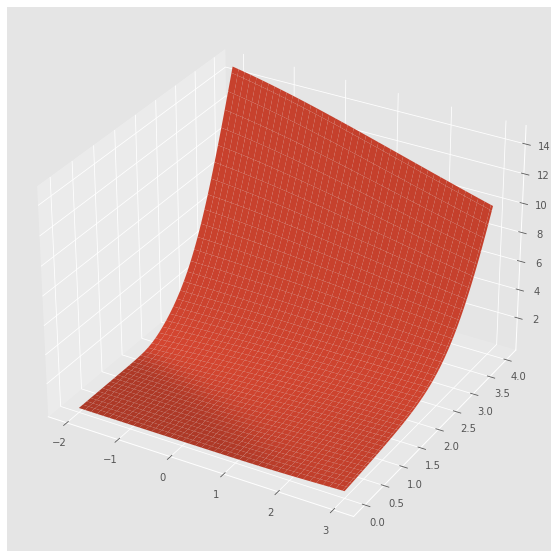

In [15]:
"""
Prediction Errors
"""
model = ffn
moneyness = np.exp(Xs[:, f_to_i("log(S/K)")])
ttm = np.exp(Xs[:, f_to_i("ttm")])
true = X_df['call_true']
intrinsic_val = np.maximum(moneyness - 1.0, 0)
preds = model.predict(Xs)
try:
    preds = preds.reshape(-1)
except:
    pass

"""
Compute all Gradients, Hessian
"""

X_tensor = tf.Variable(Xs)
with tf.GradientTape() as tape2:
    with tf.GradientTape() as tape:
        output = model(X_tensor)
        grads = tape.gradient(output, X_tensor)
    hessian1 = tape2.gradient(grads[:, f_to_i("log(S/K)")], X_tensor)

grads = grads.numpy()
hessian_moneyness = hessian1.numpy()[:, [0]]
    
all_res += [bs_eval_wrapper(X_df, 
                    true_val = X_df['call_true'].values, 
                    preds = preds,
                    grads = grads,
                    hessian_moneyness = hessian_moneyness,
                    lower_bound = intrinsic_val, 
                    upper_bound = None,
                    METHOD = "standard_ffn"
                    )]

"""
Visualise call surface
"""
SK = np.linspace(-2, 3, 128) 
ts = np.linspace(0, 4, 128)
X = np.array(list(product(SK, ts)))
visualise_surface(SK, ts, model(X).numpy())

# NN with a homogeneity hint

In [16]:
%run examples/nn_archi.py

In [17]:
CALLBACKS = [EarlyStopping(patience=5)]
opt = Adam(learning_rate = 1e-1)

intrinsic_value = np.maximum(np.exp(Xs[:,0]) - 1.0 ,0 )

gated_model = homogeneity_network(2, 100, seed = 42)
gated_model.compile(optimizer=opt, loss=loss_fn, metrics = METRICS)
history = gated_model.fit([Xs[:,0], Xs[:,1]], 
                    ys, 
                  epochs = EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_split = VAL_SPLIT,
                  shuffle=True,
                  callbacks=CALLBACKS)

Epoch 1/10
1639/1639 [==============================] - 3s 2ms/step - loss: 0.0078 - mean_absolute_error: 0.0326 - root_mean_squared_error: 0.0794 - val_loss: 0.0014 - val_mean_absolute_error: 0.0232 - val_root_mean_squared_error: 0.0378
Epoch 2/10
1639/1639 [==============================] - 2s 1ms/step - loss: 0.0033 - mean_absolute_error: 0.0256 - root_mean_squared_error: 0.0578 - val_loss: 8.0972e-04 - val_mean_absolute_error: 0.0168 - val_root_mean_squared_error: 0.0285
Epoch 3/10
1639/1639 [==============================] - 2s 1ms/step - loss: 0.0033 - mean_absolute_error: 0.0237 - root_mean_squared_error: 0.0573 - val_loss: 0.0027 - val_mean_absolute_error: 0.0289 - val_root_mean_squared_error: 0.0524
Epoch 4/10
1639/1639 [==============================] - 2s 1ms/step - loss: 0.0020 - mean_absolute_error: 0.0209 - root_mean_squared_error: 0.0448 - val_loss: 0.0015 - val_mean_absolute_error: 0.0202 - val_root_mean_squared_error: 0.0386
Epoch 5/10
1639/1639 [======================

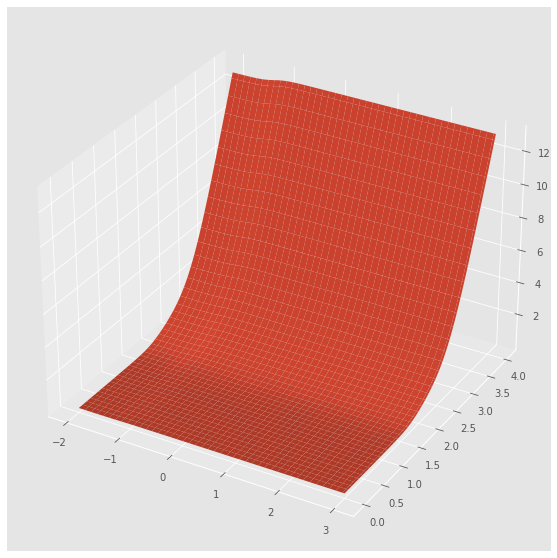

In [21]:
preds = (gated_model.predict([Xs[:,0], Xs[:,1]]).reshape(-1)).reshape(-1)

"""
Compute all Gradients, Hessian
"""

X_tensor = tf.Variable(Xs)
with tf.GradientTape() as tape2:
    with tf.GradientTape() as tape:
        output = gated_model([X_tensor[:,0], X_tensor[:,1]])
        grads = tape.gradient(output, X_tensor)
    hessian1 = tape2.gradient(grads[:, f_to_i("log(S/K)")], X_tensor)
    
grads = grads.numpy()
hessian_moneyness = hessian1.numpy()[:, [0]]
    
# all_res += [bs_eval_wrapper(X_df, 
#                     true_val = X_df['call_true'].values, 
#                     preds = preds,
#                     grads = grads,
#                     hessian_moneyness = hessian_moneyness,
#                     lower_bound = intrinsic_val, 
#                     upper_bound = None,
#                     METHOD = "homogeneity_network"
#                     )]

"""
Visualise call surface
"""
SK = np.linspace(-2, 3, 128) 
ts = np.linspace(0, 4, 128)
X = np.array(list(product(SK, ts)))
visualise_surface(SK, ts, gated_model([X[:,0], X[:,1]]).numpy())

In [25]:
pd.concat(all_res).T.style.background_gradient()

,standard_ffn,homogeneity_network
pred_l1,0.010020,0.074933
pred_l2,0.020352,0.161566
pred_l_inf,0.218925,1.024783
pred_lower_bound_violation,0.106888,0.217255
PDE_mean,0.002849,0.038285
PDE_l1,0.061898,0.074110
PDE_l2,0.119573,0.159377
PDE_l_inf,1.791467,3.453306
monotonicity_error,0.000000,0.000000
time_value_error,0.009628,0.000000


# Polynomial Basis

<AxesSubplot:>

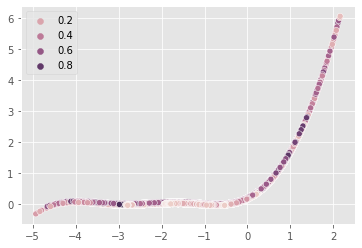

In [30]:
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
X2 = SplineTransformer(n_knots=5, degree=3, knots='uniform', extrapolation='constant').fit_transform(Xs)

reg = LinearRegression(fit_intercept=False).fit(X2, X_df['call_payoff'])
sns.scatterplot(x = Xs[:, f_to_i("log(S/K)")], 
                y = reg.predict(X2), 
                hue = Xs[:, f_to_i("ttm")])